In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('/content/null.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (101315, 21)


In [3]:
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
column type,int64,int64,object,object,object,object,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,158,355,158,158,...,158,158,158,158,158,158,158,158,158,158
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.155949,0.350392,0.155949,0.155949,...,0.155949,0.155949,0.155949,0.155949,0.155949,0.155949,0.155949,0.155949,0.155949,0.155949


In [4]:
count_flights = df['airport_name'].value_counts()

In [5]:
print(count_flights)

Nashville, TN: Nashville International                        913
Pittsburgh, PA: Pittsburgh International                      913
Raleigh/Durham, NC: Raleigh-Durham International              906
New Orleans, LA: Louis Armstrong New Orleans International    895
Detroit, MI: Detroit Metro Wayne County                       889
                                                             ... 
St. Augustine, FL: Northeast Florida Regional                   5
Williamsport, PA: Williamsport Regional                         3
Youngstown/Warren, OH: Youngstown-Warren Regional               1
Fort Collins/Loveland, CO: Northern Colorado Regional           1
Tokeen, AK: Tokeen Airport                                      1
Name: airport_name, Length: 384, dtype: int64


In [6]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,arr_del15,355,99.649608
1,nas_ct,158,99.844051
2,nas_delay,158,99.844051
3,weather_delay,158,99.844051
4,carrier_delay,158,99.844051
5,arr_delay,158,99.844051
6,arr_diverted,158,99.844051
7,arr_cancelled,158,99.844051
8,late_aircraft_ct,158,99.844051
9,security_ct,158,99.844051


We see that the variables filling factor is quite good (> 97%). Since the scope of this work is not to establish the state-of-the-art in predicting flight delays, I decide to proceed without trying to impute what's missing and I simply remove the entries that contain missing values.

In [7]:
df.dropna(inplace = True)

In [8]:
df.describe()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
count,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000
mean,2019.515184,6.282518,336.669057,58.073217,18.493519,2.051222,17.268145,0.153786,20.106579,7.964828,0.774683,3824.531220,1321.840987,213.024643,839.930705,7.384776,1442.342948
std,1.559895,3.440055,943.091834,163.327000,47.080815,6.884791,58.479922,0.734822,63.098420,50.986874,3.398931,11725.452846,3944.873970,811.010107,3393.552629,44.338997,4640.573106
min,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.000000,3.000000,42.000000,5.000000,1.930000,0.000000,0.970000,0.000000,1.000000,0.000000,0.000000,268.000000,87.000000,0.000000,25.000000,0.000000,42.000000
50%,2019.000000,6.000000,90.000000,14.000000,5.300000,0.250000,3.210000,0.000000,3.980000,1.000000,0.000000,869.000000,318.000000,12.000000,120.000000,0.000000,255.000000
75%,2021.000000,9.000000,227.000000,40.000000,14.640000,1.670000,9.880000,0.000000,12.680000,4.000000,1.000000,2525.000000,992.000000,132.000000,402.000000,0.000000,919.000000
max,2022.000000,12.000000,21931.000000,4176.000000,1147.000000,226.000000,1884.420000,58.690000,1531.810000,4951.000000,154.000000,429194.000000,151581.000000,28294.000000,112018.000000,3760.000000,147167.000000


In [9]:
print("Nb of airports: {}".format(len(df['airport'].unique())))

Nb of airports: 383


In [10]:
df.corr()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
year,1.000000,-0.155292,-0.045588,-0.052033,0.003336,-0.006049,-0.078586,0.041262,-0.064160,0.020846,-0.029124,-0.042670,0.000536,-0.005473,-0.073646,0.025040,-0.053697
month,-0.155292,1.000000,0.002900,0.000730,0.003804,-0.013703,-0.003595,0.015542,0.003698,-0.062236,-0.002336,-0.003591,-0.002083,-0.017889,-0.006355,0.011269,0.000362
arr_flights,-0.045588,0.002900,1.000000,0.912000,0.888081,0.721881,0.807804,0.452611,0.865310,0.394523,0.642070,0.873379,0.873863,0.650280,0.691074,0.370907,0.841372
arr_del15,-0.052033,0.000730,0.912000,1.000000,0.933790,0.758786,0.908542,0.480457,0.961273,0.334992,0.699186,0.968492,0.901808,0.688448,0.825927,0.387705,0.952495
carrier_ct,0.003336,0.003804,0.888081,0.933790,1.000000,0.740101,0.740158,0.504663,0.898304,0.326138,0.640702,0.895217,0.938763,0.657001,0.642851,0.412084,0.875077
weather_ct,-0.006049,-0.013703,0.721881,0.758786,0.740101,1.000000,0.661968,0.340187,0.685265,0.260528,0.631252,0.797164,0.789225,0.923332,0.622832,0.291192,0.723694
nas_ct,-0.078586,-0.003595,0.807804,0.908542,0.740158,0.661968,1.000000,0.379397,0.795993,0.299652,0.655739,0.893487,0.748974,0.615310,0.944713,0.306632,0.819592
security_ct,0.041262,0.015542,0.452611,0.480457,0.504663,0.340187,0.379397,1.000000,0.466693,0.165020,0.315286,0.431358,0.440666,0.285873,0.302166,0.804394,0.436704
late_aircraft_ct,-0.064160,0.003698,0.865310,0.961273,0.898304,0.685265,0.795993,0.466693,1.000000,0.315695,0.651457,0.918834,0.848428,0.617443,0.711165,0.370750,0.968896
arr_cancelled,0.020846,-0.062236,0.394523,0.334992,0.326138,0.260528,0.299652,0.165020,0.315695,1.000000,0.279014,0.342448,0.338760,0.263177,0.285344,0.126772,0.321426


In [11]:
# for column1 in df: 
#      for column2 in df: 
#             df.plot(kind='scatter', x=column1, y=column2, color='r')

In [12]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [13]:
df.dtypes

year                     int64
month                    int64
carrier                 object
carrier_name            object
airport                 object
airport_name            object
arr_flights            float64
arr_del15              float64
carrier_ct             float64
weather_ct             float64
nas_ct                 float64
security_ct            float64
late_aircraft_ct       float64
arr_cancelled          float64
arr_diverted           float64
arr_delay              float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
dtype: object

In [14]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')

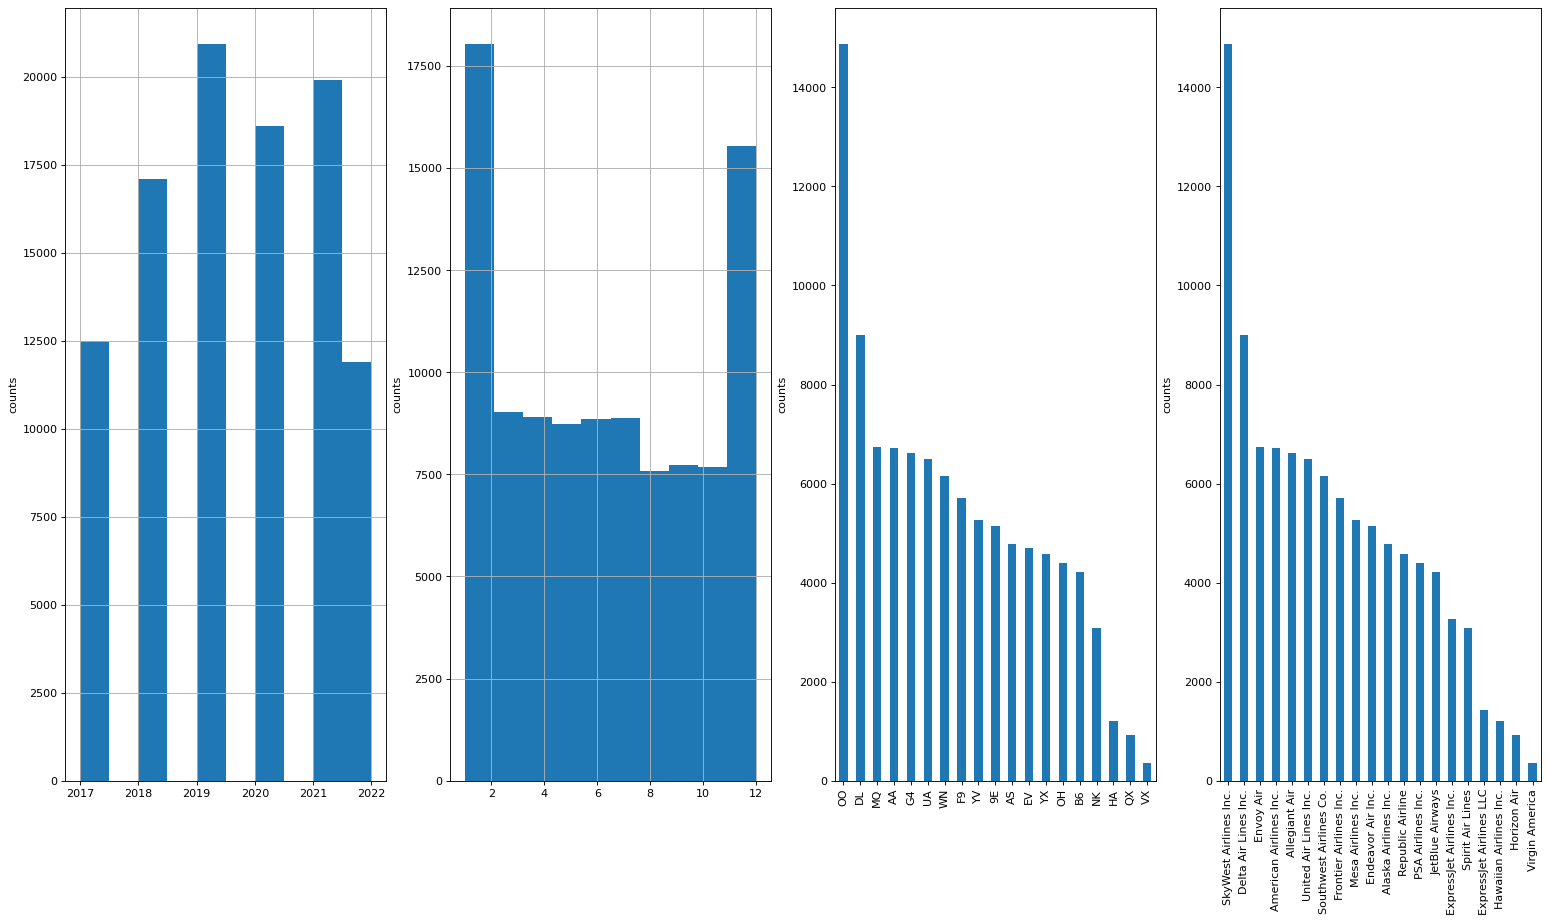

In [15]:
plotPerColumnDistribution(df, 10, 5)

In [16]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['arr_delay'].groupby(df['carrier']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
carrier,,,,
VX,0.0,59600.0,353.0,3879.657224
QX,0.0,41762.0,929.0,1237.678149
HA,0.0,32537.0,1202.0,1523.264559
NK,0.0,69102.0,3091.0,4131.395018
B6,0.0,160383.0,4218.0,6174.654576
OH,0.0,157438.0,4399.0,2550.615594
YX,0.0,89091.0,4583.0,3006.063714
EV,0.0,106924.0,4691.0,2418.601364
AS,0.0,83952.0,4782.0,1962.802802


In [17]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['arr_delay'].groupby(df['airport']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
airport,,,,
FNL,0.0,0.0,1.0,0.000000
YNG,119.0,119.0,1.0,119.000000
IPT,212.0,941.0,3.0,631.333333
UST,17.0,1096.0,5.0,586.600000
ART,0.0,1377.0,6.0,725.333333
...,...,...,...,...
DTW,0.0,83386.0,889.0,8578.980877
MSY,0.0,29313.0,891.0,3069.169473
RDU,0.0,21340.0,906.0,3271.732892


In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["carrier"] = le.fit_transform(df[["carrier"]]);
df["carrier_name"] = le.fit_transform(df[["carrier_name"]]);
df["airport"] = le.fit_transform(df[["airport"]]);
df["airport_name"] = le.fit_transform(df[["airport_name"]]);



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
from sklearn.preprocessing import MinMaxScaler
Y = df.iloc[:,-1]
gh = df.drop(['late_aircraft_delay'], axis=1)


scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(
    gh, Y, test_size=.50, random_state=42)


X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [20]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import train_test_split
# Y = df.iloc[:,-1]
# gh = df.drop(['late_aircraft_delay'], axis=1)

# logModel = LogisticRegression(C=1, penalty='l1', solver='liblinear')
# #LogisticRegression(C=1, penalty='l1', solver='liblinear')
# param_grid = [    
#     {'penalty' : ['l1','l2', 'elasticnet', 'none'],
#     'C' : np.logspace(-4, 4, 20),
#     'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
#     'max_iter' : [100, 1000, 2500, 5000]
#     }
# ]
# clf = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
# best_clf = clf.fit(X_train, y_train)

In [21]:
# lf = LogisticRegression()
# best_clf=lf.fit(X_train,y_train)
# y_pred=lf.predict(X_test)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# from sklearn.datasets import make_classification
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# X, y = make_classification(random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# pipe = make_pipeline(StandardScaler(), LogisticRegression())
# pipe.fit(X_train, y_train)  # apply scaling on training data
# Pipeline(steps=[('standardscaler', StandardScaler()),
#                 ('logisticregression', LogisticRegression())])

# pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.


In [23]:
from sklearn.tree import DecisionTreeClassifier
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)


# fit the model
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [25]:
y_pred_gini = clf_gini.predict(X_test)

In [26]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))

Model accuracy score with criterion gini index: 0.1600


In [ ]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model,X,y,scoring="neg_mean_squared_error",cv=5))
    return rmse

In [28]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
my_model.fit(X_train, y_train)

[02:53:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [38]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
my_model.fit(X_train1, y_train1)

[03:10:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [42]:
from xgboost import XGBRegressor

my_model1 = XGBRegressor()
my_model1.fit(X_train2, y_train2)

[03:14:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [43]:
from sklearn.metrics import mean_absolute_error

predictions2 = my_model1.predict(X_test2)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions2, y_test2)))

Mean Absolute Error: 203.88330860520978


In [37]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    gh, Y, test_size=.33, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    gh, Y, test_size=.20, random_state=42)


In [44]:
from xgboost import XGBRegressor

my_model3 = XGBRegressor()
my_model3.fit(X_train1, y_train1)

[03:18:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [45]:
from sklearn.metrics import mean_absolute_error

predictions13 = my_model3.predict(X_test1)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions13, y_test1)))

Mean Absolute Error: 204.83533656016422


In [30]:
from sklearn.metrics import mean_absolute_error

predictions = my_model.predict(X_test)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_test)))

Mean Absolute Error: 0.08051734924316406


In [33]:
accuracy = 1-0.080
print(accuracy)

0.92


In [34]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], 
             verbose=False)

[03:00:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.05, n_estimators=1000, n_jobs=4)

In [ ]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_model.fit(X_train1, y_train1, 
             early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], 
             verbose=False)

In [35]:
predictions = my_model.predict(X_test)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_test)))

Mean Absolute Error: 0.13222264528274535


In [36]:
accuracy = 1-0.13
print(accuracy)

0.87


In [46]:
# import SVC classifier
from sklearn.svm import SVC


# import metrics to compute accuracy
from sklearn.metrics import accuracy_score


# instantiate classifier with default hyperparameters
svc=SVC() 


# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.9200
